# CNN Lifecycle Visualization

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
bat_sz = 32
pix_sz = 500
epochs = 30
l_r = 0.0001
device = torch.device('cpu')

In [3]:
# CNN 
class CancerDetectionCNN(nn.Module):
    def __init__(self):
        super(CancerDetectionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # in order to send in normalized activations
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * (pix_sz // 16) * (pix_sz // 16), 512), 
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(512, 1),  
            nn.Sigmoid() 
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x




In [4]:
menopause = 1           # 0 fro pre menopause and 1 for post menopause

In [5]:
# Load trained model
if menopause:
    model = CancerDetectionCNN()
    model.load_state_dict(torch.load('models/cancer_detection_model_post.pth'))
    model.eval()
else:
    model = CancerDetectionCNN()
    model.load_state_dict(torch.load('models/cancer_detection_model_pre.pth'))
    model.eval()

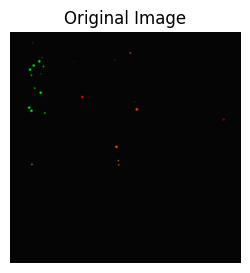

In [6]:

# Load and preprocess the input image
img_path = 'image.png'
transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

image = Image.open(img_path).convert('RGB')
input_image = transform(image).unsqueeze(0)
# image
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [7]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv_layers[0].register_forward_hook(get_activation('conv1'))
model.conv_layers[4].register_forward_hook(get_activation('conv2'))
model.conv_layers[8].register_forward_hook(get_activation('conv3'))
model.conv_layers[12].register_forward_hook(get_activation('conv4'))

with torch.no_grad():
    output = model(input_image)

if output.item()<0.5:
    print(f"The predicted condition is : No cancer")
else:
    print(f"The predicted condition is : Cancer")

The predicted condition is : No cancer


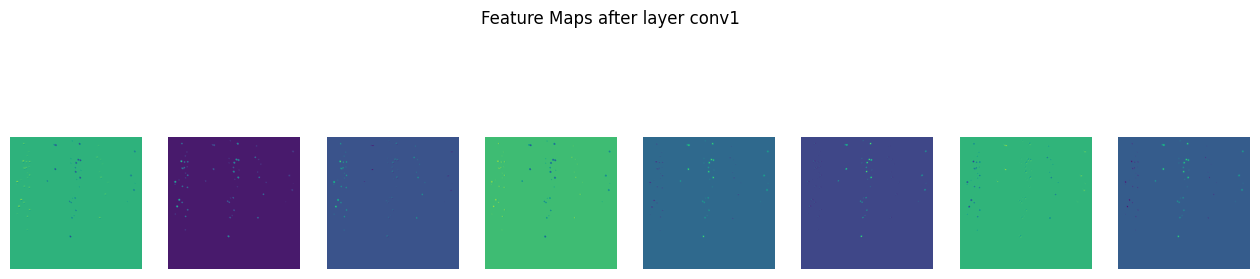

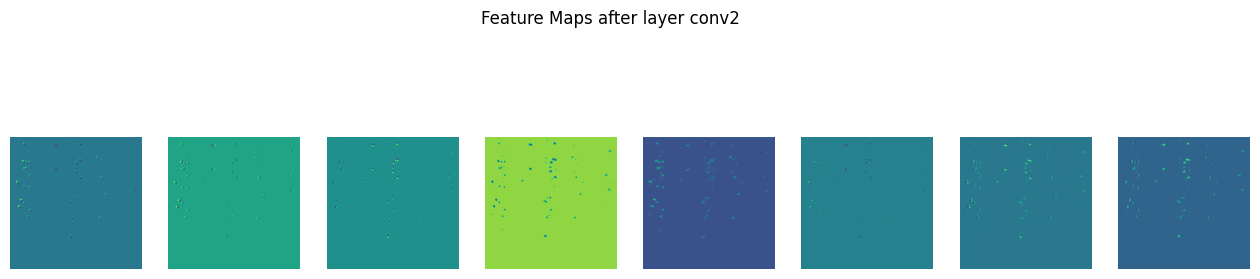

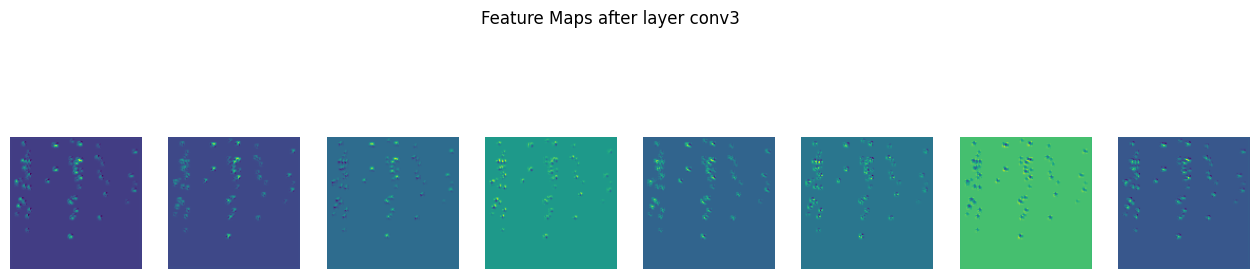

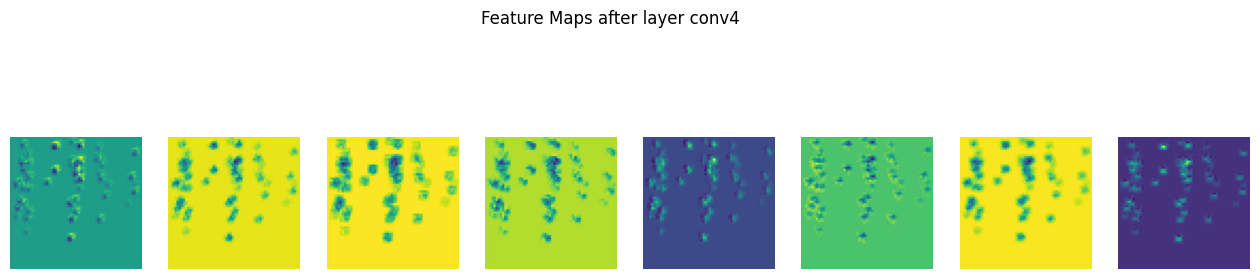

In [37]:
for name, act in activation.items():
    num_feature_maps = act.shape[1]
    fig, axes = plt.subplots(1, min(num_feature_maps, 8), figsize=(16, 4))
    fig.suptitle(f'Feature Maps after layer {name}')

    for i in range(min(num_feature_maps, 8)):
        axes[i].imshow(act[0, i].cpu(), cmap='viridis')
        axes[i].axis('off')

    plt.show()
